# 영화 추천 시스템 만들기

### 추천 시스템 종류
협업 필터링은 다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악하지만, 콘텐츠 기반 필터링은 아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악. 다시 말해, 협업 필터링에서는 아이템과 사용자 간의 행동 또는 관계에만 주목할 뿐 아이템 자체의 고유한 속성에 주목하지 않는다.콘텐츠 기반 필터링에서는 아이템 자체의 속성에만 주목하고 사용자와 아이템 간의 관련성 에는 주목하지 않음

### 데이터 사용 전제

- Movielens 데이터 활용

- 별점 데이터는 대표적인 explicit 데이터,  하지만 implicit 데이터로 간주하고 테스트해 볼 수 있음
(선호도가 숫자로 명시되는 데이터 - explicit data : 좋아요, 별점, 시청수 등)


- 별점을 시청횟수로 해석해서 생각 : implicit data로 변환해 생각


#### 암묵적 피드백 데이터 특징
1. 부정적인 피드백이 없다.(No Negative Feedback)
2. 애초에 잡음이 많다.(Inherently Noisy)
3. 수치는 신뢰도를 의미한다.(The numerical value of implicit feedback indicates confidence)
4. Implicit-feedback Recommender System의 평가는 적절한 방법을 고민해봐야 한다.(Evaluation of implicit-feedback recommender requires appropriate measures)


- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외



### 1) 데이터 준비와 전처리

In [1]:
import pandas as pd
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [6]:
ratings = pd.merge(ratings,movies, how='left', on=['movie_id'])
ratings.head(5)

ratings

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),Drama|War
836474,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
836476,6040,1096,4,956715648,Sophie's Choice (1982),Drama


### 좋아하는 영화 있나 살펴보기

In [7]:
#검색 쉽게 제목 소문자로 바꾸기
ratings['title'] = ratings['title'].str.lower()
ratings.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,978302109,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,my fair lady (1964),Musical|Romance
3,1,3408,4,978300275,erin brockovich (2000),Drama
4,1,2355,5,978824291,"bug's life, a (1998)",Animation|Children's|Comedy
5,1,1197,3,978302268,"princess bride, the (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,978302039,ben-hur (1959),Action|Adventure|Drama
7,1,2804,5,978300719,"christmas story, a (1983)",Comedy|Drama
8,1,594,4,978302268,snow white and the seven dwarfs (1937),Animation|Children's|Musical
9,1,919,4,978301368,"wizard of oz, the (1939)",Adventure|Children's|Drama|Musical


In [8]:
# Avatar
ratings[ratings['title'].str.contains('avartar')]['movie_id'].unique()

array([], dtype=int64)

영화가 없다. 다른 영화를 찾아보자

In [9]:
# Home Alone
ratings[ratings['title'].str.contains('home alone')]['movie_id'].unique()

array([ 586, 1707, 2953])

In [10]:
# The Shawshank Redemption
ratings[ratings['title'].str.contains('the shawshank redemption')]['movie_id'].unique()

array([], dtype=int64)

In [11]:
# E.T. the Extra-Terrestrial 
ratings[ratings['title'].str.contains('e.t. the extra')]['movie_id'].unique()

array([1097])

In [12]:
# The Wizard Of Oz
ratings[ratings['title'].str.contains('wizard of oz')]['movie_id'].unique()

array([919])

In [13]:
# gone with the wind
ratings[ratings['title'].str.contains('gone with the wind')]['movie_id'].unique()

array([920])

In [14]:
# shawshank redemption
ratings[ratings['title'].str.contains('shawshank redemption')]['movie_id'].unique()

array([318])

검색 성공한 영화
- Home Alone
- E.T. the Extra-Terrestrial
- The Wizard Of Oz
- gone with the wind
- shawshank redemption

### 2)  MF model을 구성

### 데이터 분석

- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

pandas.DataFrame.nunique()은 특정 컬럼에 포함된 유니크한 데이터의 개수를 알아보는데 유용

In [15]:
# 유저 수
ratings['user_id'].nunique()

6039

In [16]:
# 영화 갯수
ratings['movie_id'].nunique()

3628

In [17]:
# 인기 많은 movie
    
movie_count = ratings.groupby('title')['user_id'].count()
cnt = movie_count.sort_values(ascending=False)
cnt.head(30)


title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

In [18]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [19]:
# 유저별 ranking 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['counts'].median()
user_median.describe()
# ratings

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

## 데이터 컬럼에서 필요한 부분만 추출

In [20]:
#원본 살리기 위해 복제
df = ratings.copy()
df

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,978302109,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,my fair lady (1964),Musical|Romance
3,1,3408,4,978300275,erin brockovich (2000),Drama
4,1,2355,5,978824291,"bug's life, a (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,platoon (1986),Drama|War
836474,6040,1094,5,956704887,"crying game, the (1992)",Drama|Romance|War
836475,6040,562,5,956704746,welcome to the dollhouse (1995),Comedy|Drama
836476,6040,1096,4,956715648,sophie's choice (1982),Drama


In [21]:
df_fin = df[['user_id','title', 'counts']]
df_fin.head()

,user_id,title,counts
0,1,one flew over the cuckoo's nest (1975),5
1,1,james and the giant peach (1996),3
2,1,my fair lady (1964),3
3,1,erin brockovich (2000),4
4,1,"bug's life, a (1998)",5


### 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가

In [22]:

my_favorite = ['e.t. the extra-terrestrial (1982)' , 'shawshank redemption, the (1994)' ,'wizard of oz, the (1939)' ,'Home Alone (1990)' ,'Gone with the Wind (1939)']

#minse가 별점 5점 줌
my_playlist = pd.DataFrame({'user_id': ['minse']*5, 'title': my_favorite, 'counts':[5]*5})

if not df_fin.isin({'user_id':['minse']})['user_id'].any():  # user_id에 'minse'이라는 데이터가 없다면
    df_fin = df_fin.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

df_fin.tail(10)    # 잘 추가되었는지 확인해 봅시다.

,user_id,title,counts
836473,6040,platoon (1986),3
836474,6040,"crying game, the (1992)",5
836475,6040,welcome to the dollhouse (1995),5
836476,6040,sophie's choice (1982),4
836477,6040,e.t. the extra-terrestrial (1982),4
0,minse,e.t. the extra-terrestrial (1982),5
1,minse,"shawshank redemption, the (1994)",5
2,minse,"wizard of oz, the (1939)",5
3,minse,Home Alone (1990),5
4,minse,Gone with the Wind (1939),5


모델에 활용하기 위한 전처리

In [24]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df_fin['user_id'].unique()
movie_unique = df_fin['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['minse'])    # 6038명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 합니다. 
print(movie_to_idx['e.t. the extra-terrestrial (1982)'])

6039
26


In [25]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_ratings = df_fin['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(df_fin):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    df_fin['user_id'] = temp_user_ratings   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = df_fin['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(df_fin):
    print('movie column indexing OK!!')
    df_fin['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

df_fin.tail(10)

user_id column indexing OK!!
movie column indexing OK!!


,user_id,title,counts
836473,6038,1030,3
836474,6038,986,5
836475,6038,311,5
836476,6038,142,4
836477,6038,26,4
0,6039,26,5
1,6039,157,5
2,6039,9,5
3,6039,3628,5
4,6039,3629,5


### 4) CSR matrix 만들기

In [29]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = df_fin['user_id'].nunique()
num_movie = df_fin['title'].nunique()

csr_data = csr_matrix((df_fin.counts, (df_fin.user_id, df_fin.title)), shape= (num_user, num_movie))
csr_data

<6040x3630 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [30]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### 5)  als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지


- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지


- use_gpu : GPU를 사용할 것인지


- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지


factors과 iterations를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 함

In [31]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [32]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3630x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [33]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

### 살펴볼 사항
- minse 벡터와 antman의 벡터를 어떻게 만들고 있는지  파악
- 두 벡터를 곱하면 어떤 값이 나오는지 파악


In [35]:
minse, antman = user_to_idx['minse'], movie_to_idx['e.t. the extra-terrestrial (1982)']
minse_vector, antman_vector = als_model.user_factors[minse], als_model.item_factors[antman]

print('슝=3')

슝=3


In [36]:
minse_vector.shape

(300,)

In [37]:
antman_vector.shape

(300,)

In [38]:
np.dot(minse_vector, antman_vector)

0.86646205

#### 예상 - 내가 5점을 메긴 영화니까 유사도는 1이  나올 것이다!

#### 타임스탬프를 썼을 때
0.00037899133 가량의 유사도가 나옴. timestamp를 다시 넣어보자 

#### 타임스탬프 항을 다시 추가했을 때
0.00014019936 이라는 기염을 토했다. 평점을 매기는 시간은 잠재요인 분석에 아무 도움이 안되는 것으로 여겨진다. 다시 빼자.

### 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 모델이 예측한 나의 선호도를 파악

AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화를 찾기



In [39]:
favorite_movie = 'e.t. the extra-terrestrial (1982)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(26, 0.9999999),
 (2851, 0.32673585),
 (3629, 0.326691),
 (3452, 0.32627454),
 (3628, 0.32602176),
 (3541, 0.3244841),
 (3517, 0.3235755),
 (3047, 0.32305768),
 (3597, 0.32194448),
 (3110, 0.32189506),
 (3423, 0.32144445),
 (3119, 0.32129192),
 (3613, 0.32109037),
 (2936, 0.32082376),
 (3319, 0.32064274)]

(영화의 id, 유사도) Tuple 로 반환하고 있다. 영화의 id를 다시 영화의 이름으로 매핑하기 

In [40]:
#movie_to_idx를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['e.t. the extra-terrestrial (1982)',
 'murder! (1930)',
 'Gone with the Wind (1939)',
 'beans of egypt, maine, the (1994)',
 'Home Alone (1990)',
 'smashing time (1967)',
 'paralyzing fear: the story of polio in america, a (1998)',
 'knightriders (1981)',
 'inheritors, the (die siebtelbauern) (1998)',
 'so dear to my heart (1949)',
 'battle of the sexes, the (1959)',
 'ogre, the (der unhold) (1996)',
 'lured (1947)',
 'king in new york, a (1957)',
 'miss julie (1999)']

In [41]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


In [43]:
get_similar_movie('so dear to my heart (1949)')

['so dear to my heart (1949)',
 'cavalcade (1933)',
 'male and female (1919)',
 'neon bible, the (1995)',
 "i don't want to talk about it (de eso no se habla) (1993)",
 'daens (1992)',
 "another man's poison (1952)",
 'number seventeen (1932)',
 'century (1993)',
 "brother's kiss, a (1997)"]

### 7) 내가 좋아하는 영화와 비슷한 영화를 추천

In [44]:
user = user_to_idx['minse']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(91, 0.18811098),
 (601, 0.15687299),
 (23, 0.15083024),
 (100, 0.14670417),
 (322, 0.14489588),
 (678, 0.1429142),
 (47, 0.14231123),
 (51, 0.13417104),
 (794, 0.13407622),
 (0, 0.12934977),
 (121, 0.12769045),
 (7, 0.1269759),
 (222, 0.121776015),
 (269, 0.12144269),
 (170, 0.115417026),
 (733, 0.11031351),
 (120, 0.10643654),
 (1370, 0.10316932),
 (501, 0.102850065),
 (44, 0.10170111)]

In [45]:
[idx_to_movie[i[0]] for i in movie_recommended]

['close encounters of the third kind (1977)',
 'citizen kane (1941)',
 "schindler's list (1993)",
 'amadeus (1984)',
 'babe (1995)',
 'willy wonka and the chocolate factory (1971)',
 'to kill a mockingbird (1962)',
 'fargo (1996)',
 'arlington road (1999)',
 "one flew over the cuckoo's nest (1975)",
 'silence of the lambs, the (1991)',
 'christmas story, a (1983)',
 'pulp fiction (1994)',
 'goodfellas (1990)',
 'being john malkovich (1999)',
 'this is spinal tap (1984)',
 'raiders of the lost ark (1981)',
 'killing fields, the (1984)',
 'treasure of the sierra madre, the (1948)',
 'star wars: episode iv - a new hope (1977)']

## 기여도 확인
AlternatingLeastSquares 클래스에 구현된 explain 메서드를 사용하면 제가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인

In [47]:
recom = movie_to_idx['close encounters of the third kind (1977)']
explain = als_model.explain(user, csr_data, itemid=recom)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('e.t. the extra-terrestrial (1982)', 0.11405891803547506),
 ('wizard of oz, the (1939)', 0.04412559843304227),
 ('shawshank redemption, the (1994)', 0.02738719954293763),
 ('Gone with the Wind (1939)', -0.0011561352765997862),
 ('Home Alone (1990)', -0.0011917845537380224)]

close encounters of the third kind (1977) 이 영화를 추천해 준 이유 중 가장 강한 척도는 영화 ET였다. ET가 11%의 기여도를 나타낸다.

### 추천 알고리즘이 정해준 내가 다음에 볼 영화
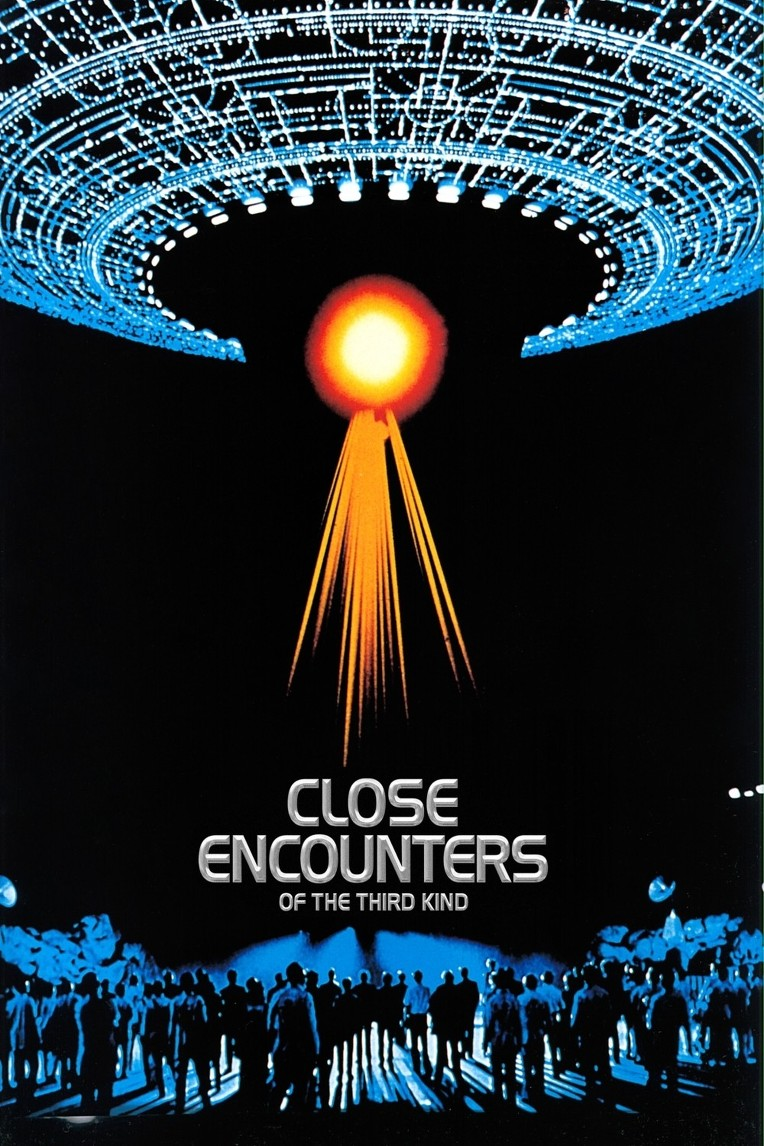
《미지와의 조우》(영어: Close Encounters Of The Third Kind)는 1977년에 개봉한 미국의 SF 영화로, 스티븐 스필버그 감독의 초기작이다. 리처드 드라이퍼스, 프랑수아 트뤼포, 테리 가, 멀린다 딜런, 밥 밸러밴 등이 출연했다. 중산층 노동자 로이를 중심으로, 미국에 갑작스레 나타난 외계인의 UFO와 접촉한 사람들의 이야기를 다룬다.


et와 같은 우주 판타지인듯 하다. E.T.를 좋아하는 사람이라면, 같은 감독인 스티븐 스필버그의 다른 작품도 좋아할 것이 분명하다. 꽤 잘 판단하는 것처럼 보여졌다.


## 회고

처음에 숫자열 인덱싱을 다시 스트링 값으로 바꿔서, 영화 아이디를 영화 제목으로 바꾸는 것을 시도했는데, 자꾸 리스트 길이가 맞지 않다고 나와 애먹었다. 

해결책으로는 판다스에 merge 메서드를 이용했더니 알아서 길이가 다른 두 데이터프레임을 하나로 이어줬다. 이로써 위에서 고민했던 숫자열 인덱싱을 다시 스트링값으로 바꾸는 작업은 굳이 내가 짜지 않아도 되게 되었다. 한 방법에 매몰될 것이 아니라 다른 방법으로도 생각해 봐야한다고 느꼈다.



또한 데이터 인덱싱이 내가 임의로 추가한 영화들에 대해서는 되지 않아서 의이했는데, 알고보니 임포트한 데이터에 내가 고른 영화가 없어서 오류가 나는 것을 알게 되었다. 알집 파일에 있는 데이터와 서버에 심볼릭링크로 연결한 데이터가 서로 다르다는 사실을 너무 늦게 깨달아서 너무 많은 시간을 허비한 것 같다.

고전영화 위주로만 있는 데이터인 것을 확인하곤, 현재 데이터에 내가 찾는 영화가 있는지를 찾는 코드를 추가해 확인후 추가했다. 이렇게 하니 인덱싱이 정상적으로 되었다.
